In [1]:
import cx_Oracle
import pandas as pd

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select * from PC.L_VM_COMPLETA WHERE PERIODO <= 201910" 
df = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM

# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_full = pd.concat(df, ignore_index=True)
conn.close()
print(df_full.shape)
# Imprimir las primeras filas del DataFrame completo
print(df_full.head())
# Imprimir los tipos de datos de las columnas del DataFrame completo
print(df_full.dtypes)
# Imprimir el número de filas y columnas del DataFrame completo
print(f"Número de filas: {df_full.shape[0]}, Número de columnas: {df_full.shape[1]}")

C:\Users\pcablinski.RWD\AppData\Local\Temp\ipykernel_59612\144710793.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM


(10950473, 30)
   PERIODO  ANIO  MES  TRIMESTRE  ID_CAT1  ID_CAT2  ID_CAT3  ID_BRAND  \
0   201801  2018    1          1        2       11       57         1   
1   201802  2018    2          1        2       11       57         1   
2   201803  2018    3          1        2       11       57         1   
3   201804  2018    4          2        2       11       57         1   
4   201805  2018    5          2        2       11       57         1   

   SKU_SIZE  CUSTOMER_ID  ...  TN_LAG_03  TN_LAG_06  TN_LAG_12      CLASE  \
0      3000        10001  ...  222.11389  101.20711   99.43861  214.72336   
1      3000        10001  ...  111.54944   43.33930  198.84365  132.83419   
2      3000        10001  ...  131.27150  289.35024   92.46537  165.73507   
3      3000        10001  ...   49.61857  222.11389   13.29728   92.29410   
4      3000        10001  ...   88.44065  111.54944  101.00563  256.05760   

   CLASE_DELTA  TN_DELTA_01  TN_DELTA_02  TN_DELTA_03  TN_DELTA_06  \
0    165.1047

In [109]:
# Variables categóricas
# categorical_features = ['CUSTOMER_ID','PRODUCT_ID','ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['CUSTOMER_ID','PRODUCT_ID']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')
# Asegurarse de que las variables predictoras y objetivo estén en el formato correcto
# Imprimir los tipos de datos de las columnas del DataFrame completo
print(df_full.dtypes)

PERIODO                     int64
ANIO                     category
MES                      category
TRIMESTRE                category
ID_CAT1                  category
ID_CAT2                  category
ID_CAT3                  category
ID_BRAND                 category
SKU_SIZE                 category
CUSTOMER_ID              category
PRODUCT_ID               category
PLAN_PRECIOS_CUIDADOS    category
CUST_REQUEST_QTY            int64
CUST_REQUEST_TN           float64
TN                        float64
STOCK_FINAL               float64
MEDIA_MOVIL_3M            float64
DESVIO_MOVIL_3M           float64
TN_LAG_01                 float64
TN_LAG_02                 float64
TN_LAG_03                 float64
TN_LAG_06                 float64
TN_LAG_12                 float64
CLASE                     float64
CLASE_DELTA               float64
TN_DELTA_01               float64
TN_DELTA_02               float64
TN_DELTA_03               float64
TN_DELTA_06               float64
TN_DELTA_12   

In [110]:
# Usando este código como base para un modelo de regresión con LightGBM
# definir las variables predictoras y la variable objetivo indicando al modelo que las variables categóricas son de tipo 'category'

# Variables predictoras y objetivo
X = df_full[['PERIODO','CUSTOMER_ID','PRODUCT_ID',
'TN_DELTA_01','TN_DELTA_02','TN_DELTA_03','TN_DELTA_06','TN_DELTA_12']]
y = df_full['CLASE_DELTA']


In [114]:
# Definir los periodos de validación 201909, 201910
periodos_valid = [201908,201909,201910]


# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]

X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]



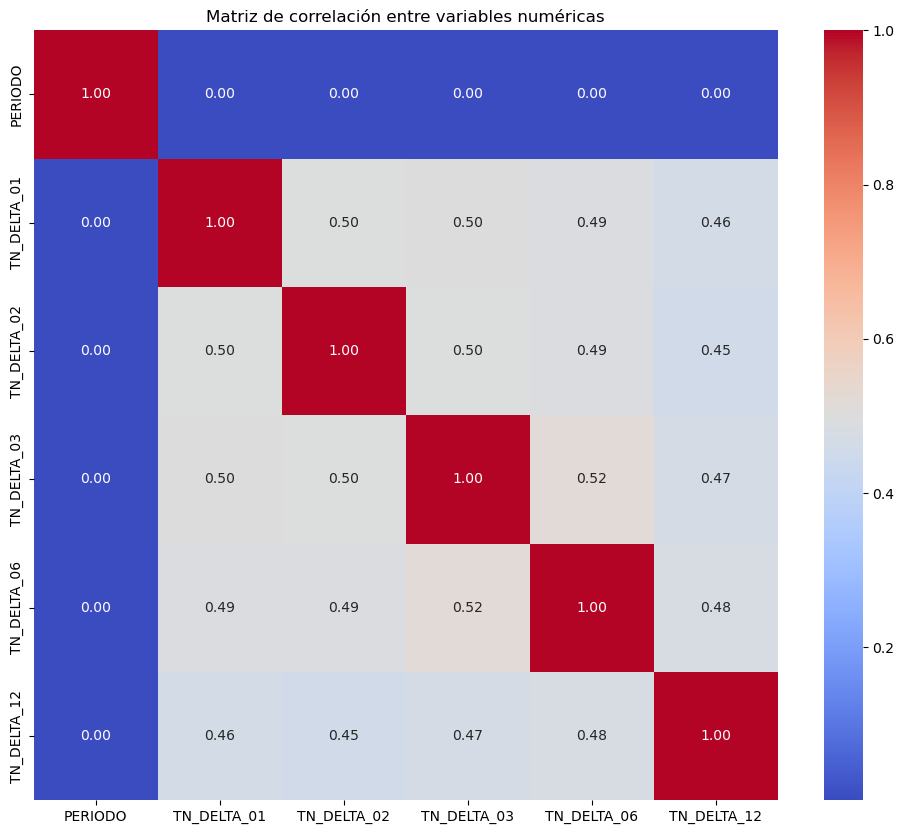

Pares de variables con correlación fuerte (> 0.7):
Series([], dtype: float64)


In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Solo selecciona las variables numéricas para la correlación
X_numericas = X.select_dtypes(include=[np.number])

# Calcula la matriz de correlación
corr_matrix = X_numericas.corr()


# Visualiza la matriz de correlación como un mapa de calor
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Opcional: muestra pares de variables con correlación fuerte
umbral = 0.7
correlaciones_fuertes = corr_matrix.abs().unstack().sort_values(ascending=False)
correlaciones_fuertes = correlaciones_fuertes[(correlaciones_fuertes < 1) & (correlaciones_fuertes > umbral)]
print("Pares de variables con correlación fuerte (> 0.7):")
print(correlaciones_fuertes)

In [115]:

import lightgbm as lgb

# Crear los datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data_list = [lgb.Dataset(X_val_list[i], label=y_val_list[i], categorical_feature=categorical_features) for i in range(len(periodos_valid))]

# Definir parámetros para regresión
params = { 
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 1024,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Entrenar el modelo con validación múltiple y early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=10000,
    valid_sets=val_data_list,
    valid_names=[f'validation_{p}' for p in periodos_valid],
    callbacks=[lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(period=500)]
)

print("Modelo de regresión entrenado con cinco conjuntos de validación (uno por cada periodo 201906-201910).")

Training until validation scores don't improve for 500 rounds
[500]	validation_201908's l1: 0.0585812	validation_201909's l1: 0.0597175	validation_201910's l1: 0.0558093
[1000]	validation_201908's l1: 0.0578526	validation_201909's l1: 0.0583706	validation_201910's l1: 0.054446
[1500]	validation_201908's l1: 0.0578417	validation_201909's l1: 0.0582442	validation_201910's l1: 0.0541707
Early stopping, best iteration is:
[1215]	validation_201908's l1: 0.0577914	validation_201909's l1: 0.0582312	validation_201910's l1: 0.0542489
Modelo de regresión entrenado con cinco conjuntos de validación (uno por cada periodo 201906-201910).


       feature    importance
3  TN_DELTA_01  3.548246e+08
4  TN_DELTA_02  1.830971e+08
5  TN_DELTA_03  1.812389e+08
0      PERIODO  1.711841e+08
1  CUSTOMER_ID  1.708743e+08
6  TN_DELTA_06  1.513467e+08
2   PRODUCT_ID  1.459133e+08
7  TN_DELTA_12  1.105467e+08


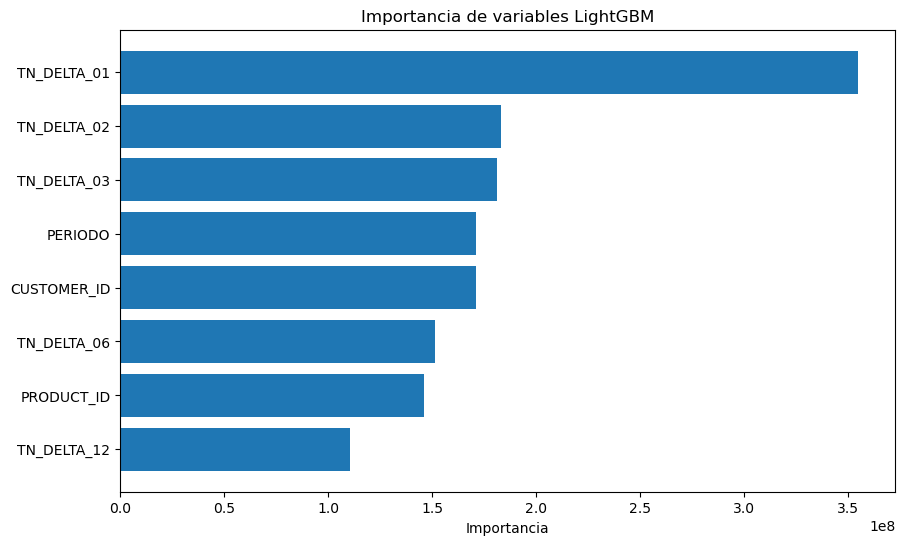

In [116]:
# Obtener la importancia de cada variable
importancia = model.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
import pandas as pd
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia)

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [117]:
# Guardo el modelo entrenado
model.save_model('modelo_regresion_lgbm_lags_delta_promedio_desvio.txt')

In [118]:
# Cargo los datos sobre los que quiero hacer predicciones

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select * from L_VM_COMPLETA where periodo = 201912" 
df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM

# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_pred_full = pd.concat(df_pred, ignore_index=True)
conn.close()

C:\Users\pcablinski.RWD\AppData\Local\Temp\ipykernel_59612\2746725373.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM


In [119]:
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

# Con el modelo entrenado, hacemos predicciones 
X_pred = df_pred_full[['PERIODO','CUSTOMER_ID','PRODUCT_ID',
'TN_DELTA_01','TN_DELTA_02','TN_DELTA_03','TN_DELTA_06','TN_DELTA_12']]


In [120]:

predictions = model.predict(X_pred)
# Agregar las predicciones al DataFrame original
df_pred_full['PREDICCIONES'] = predictions
# Imprimir las primeras filas del DataFrame con las predicciones
print(df_pred_full.head())
# Guardar el DataFrame con las predicciones en un archivo CSV
df_pred_full.to_csv('predicciones.csv', index=False)
# Imprimir el número de filas y columnas del DataFrame con las predicciones
print(f"Número de filas: {df_pred_full.shape[0]}, Número de columnas: {df_pred_full.shape[1]} con predicciones.")



   PERIODO  ANIO  MES  TRIMESTRE  ID_CAT1  ID_CAT2  ID_CAT3  ID_BRAND  \
0   201912  2019   12          4        2       11       57         1   
1   201912  2019   12          4        2       11       57         1   
2   201912  2019   12          4        2       11       57         1   
3   201912  2019   12          4        2       11       57         1   
4   201912  2019   12          4        2       11       57         1   

   SKU_SIZE CUSTOMER_ID  ...  TN_LAG_06  TN_LAG_12  CLASE  CLASE_DELTA  \
0      3000       10001  ...   65.92436  254.62373   None         None   
1      3000       10002  ...  144.07021  131.28861   None         None   
2      3000       10003  ...    0.00000   98.91454   None         None   
3      3000       10004  ...   66.71971  236.78999   None         None   
4      3000       10005  ...    0.00000   19.35723   None         None   

   TN_DELTA_01  TN_DELTA_02  TN_DELTA_03  TN_DELTA_06  TN_DELTA_12  \
0    -56.43618      4.18958     71.16694    11

In [121]:
# Con el DataFrame de predicción, actualizamos la base de datos
# el criterio es actualizar la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones
# la columnna PREDICCIONES se debe actualizar con los nuevos valores
# la clave primaria es (PERIODO, CUSTOMER_ID, PRODUCT_ID)
# Hacer commit cada 10000 filas para evitar problemas de memoria

# Conectar a la base de datos para actualizar los datos de predicción
conn = cx_Oracle.connect(user="pc", password="p201404", dsn="siatchdesa")
# Crear un cursor para ejecutar las actualizaciones
cursor = conn.cursor()
update_query = """
    UPDATE L_VM_COMPLETA_PREDICCIONES
    SET PREDICCION = NULL
"""
cursor.execute(update_query)
# Hacer commit para aplicar el cambio de NULL
conn.commit()


In [ ]:


# Imprimir mensaje de inicio de actualización
print("Iniciando actualización de la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")

# Iterar sobre las filas del DataFrame con las predicciones
for index, row in df_pred_full.iterrows():
    periodo = row['PERIODO']
    customer_id = row['CUSTOMER_ID']
    product_id = row['PRODUCT_ID']
    prediccion = row['TN'] + row['PREDICCIONES']
   # prediccion = row['PREDICCIONES']
    
    # Actualizar la tabla L_DATOS_PREDICCION con la nueva predicción
    update_query = """
        UPDATE L_VM_COMPLETA_PREDICCIONES
        SET PREDICCION = :prediccion
        WHERE PERIODO = :periodo AND CUSTOMER_ID = :customer_id AND PRODUCT_ID = :product_id
    """
    cursor.execute(update_query, {'prediccion': prediccion, 'periodo': periodo, 'customer_id': customer_id, 'product_id': product_id})  
    # Hacer commit cada 10000 filas para evitar problemas de memoria
    if index % 10000 == 0:
        conn.commit()
        print(f"Actualizadas {index} filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")
# Confirmar los cambios en la base de datos
conn.commit()
# Cerrar el cursor y la conexión
cursor.close()
conn.close()
# Imprimir mensaje de finalización
print("Actualización de la tabla  completada con las nuevas predicciones.")


Iniciando actualización de la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.
Actualizadas 0 filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.
Actualizadas 10000 filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.
